# ノートブック09: MLP回帰と波形予測

## 学習目標

このノートブックでは、MLPRegressorを使った回帰問題と時系列予測を学びます:

1. **MLPRegressor（回帰用ニューラルネットワーク）**
   - 分類と回帰の違い
   - 出力層と損失関数の違い
   - 回帰用の評価指標

2. **波形生成**
   - 複雑な高調波
   - 減衰振動
   - AM信号とチャープ

3. **時系列特徴量エンジニアリング**
   - ラグ特徴量
   - 最適なラグ数の決定

4. **波形予測**
   - 1ステップ先予測
   - 多ステップ予測
   - 再帰的予測

5. **実践的なベストプラクティス**
   - 時系列データの扱い
   - モデルの診断と改善

---

## セットアップ

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('whitegrid')
np.random.seed(42)

print("Setup complete!")

# 日本語フォント設定
import matplotlib.font_manager as fm

def setup_japanese_font():
    """日本語フォントを設定する"""
    japanese_fonts = [
        'Hiragino Sans', 'Hiragino Maru Gothic Pro', 'AppleGothic',  # macOS
        'Yu Gothic', 'MS Gothic',  # Windows
        'Noto Sans CJK JP', 'IPAexGothic', 'TakaoPGothic',  # Linux
    ]
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    return None

font_used = setup_japanese_font()
if font_used:
    print(f"Japanese font: {font_used}")


Setup complete!


---

## 1. 回帰問題の基礎

### 🎯 分類 vs 回帰: 何が違う？

機械学習の教師あり学習には、大きく分けて2つの問題があります。

```
【分類 (Classification)】
  
  入力: 画像、テキスト、数値など
  出力: カテゴリ（離散値）
  
  例:
    ・メールがスパムかどうか → {スパム, 非スパム}
    ・手書き数字の認識 → {0, 1, 2, ..., 9}
    ・病気の診断 → {陽性, 陰性}
  
  出力層: ソフトマックス関数（確率を出力）
  損失関数: 交差エントロピー損失


【回帰 (Regression)】
  
  入力: 特徴量（連続値、離散値など）
  出力: 連続値
  
  例:
    ・住宅価格の予測 → 2,500万円
    ・気温の予測 → 25.3℃
    ・株価の予測 → 1,234.56円
    ・波形の次の値の予測 → 0.732
  
  出力層: 恒等関数（そのまま出力）
  損失関数: 平均二乗誤差 (MSE)
```

---

### 🧠 MLPClassifier vs MLPRegressor

```
【MLPClassifier（分類）】

  入力層 → 隠れ層 → 隠れ層 → 出力層
                              ↓
                        ソフトマックス
                              ↓
                    確率 [0.1, 0.7, 0.2]
                              ↓
                        argmax → クラス1

  損失関数: Cross-Entropy Loss
  L = -Σ y_true × log(y_pred)


【MLPRegressor（回帰）】

  入力層 → 隠れ層 → 隠れ層 → 出力層
                              ↓
                         恒等関数
                              ↓
                      連続値: 2.347

  損失関数: Mean Squared Error (MSE)
  L = (1/n) × Σ (y_true - y_pred)²
```

---

### 📊 なぜ損失関数が違う？

```
【分類の場合】

  正解: クラス2（ワンホット: [0, 0, 1]）
  予測: [0.1, 0.2, 0.7]
  
  → 正解クラスの確率を最大化したい
  → クロスエントロピーが適切
  → 確率が0に近いと大きなペナルティ


【回帰の場合】

  正解: 25.3
  予測: 24.8
  誤差: 0.5
  
  → 予測と正解の「距離」を最小化したい
  → 二乗誤差が適切
  → 大きな誤差により大きなペナルティ
```

---

### 📈 回帰の評価指標

分類では「正解率」を使いますが、回帰では連続値を予測するため、異なる指標が必要です。

#### 1. R² スコア（決定係数）

$$R^2 = 1 - \frac{\sum (y_{true} - y_{pred})^2}{\sum (y_{true} - \bar{y})^2}$$

```
【直感的な意味】

  R² = 1.0: 完璧な予測（100%説明できている）
  R² = 0.0: 平均値で予測するのと同じ
  R² < 0:   平均値より悪い予測（モデルに問題あり）

  R² = 0.8 の解釈:
    「このモデルは、目的変数の変動の80%を説明できる」
```

#### 2. RMSE（二乗平均平方根誤差）

$$RMSE = \sqrt{\frac{1}{n}\sum (y_{true} - y_{pred})^2}$$

```
【直感的な意味】

  - 予測誤差の「平均的な大きさ」
  - 元のデータと同じ単位で解釈可能
  
  例: 気温予測で RMSE = 2.5℃
    → 平均的に 2.5℃ 程度の誤差がある
```

#### 3. MAE（平均絶対誤差）

$$MAE = \frac{1}{n}\sum |y_{true} - y_{pred}|$$

```
【RMSEとMAEの違い】

  RMSE: 大きな誤差に敏感（二乗するため）
  MAE:  すべての誤差を平等に扱う

  外れ値が多い場合 → MAEが安定
  大きな誤差を重視したい → RMSEが適切
```

---

### ⚙️ MLPRegressorの設定ポイント

```python
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    hidden_layer_sizes=(100, 50),  # 隠れ層の構造
    activation='relu',              # 隠れ層の活性化関数
    solver='adam',                  # 最適化アルゴリズム
    alpha=0.001,                    # L2正則化（過学習防止）
    learning_rate_init=0.001,       # 学習率
    max_iter=1000,                  # 最大エポック数
    early_stopping=True,            # 早期終了
    random_state=42
)
```

| パラメータ | 分類 (MLPClassifier) | 回帰 (MLPRegressor) |
|-----------|---------------------|---------------------|
| 出力層活性化 | ソフトマックス | なし（恒等関数） |
| 損失関数 | log_loss | squared_error |
| 出力 | クラスラベル/確率 | 連続値 |

---

## 2. 複雑な波形の生成

### 🌊 なぜ波形データを使うのか？

波形予測は、時系列予測の基本的なベンチマークです。

```
【波形予測が時系列予測の練習に最適な理由】

1. パターンが明確
   - 周期性、トレンド、ノイズを制御可能
   - 予測の「正解」が明確

2. 実世界への応用が広い
   - 音声・音楽信号
   - 電力需要予測
   - 株価・為替予測
   - 心電図・脳波

3. モデルの限界を理解しやすい
   - 単純な波形 → 簡単に予測
   - 複雑な波形 → 困難
   - ノイズの影響を直接観察
```

---

### 📊 4つの波形タイプと実世界での応用

#### 1. 複雑な高調波（Complex Harmonic）

$$y(t) = \sin(t) + 0.5\sin(3t) + 0.25\sin(5t) + \epsilon$$

```
【構成】
  基本波 sin(t)
  + 第3高調波 0.5×sin(3t)
  + 第5高調波 0.25×sin(5t)
  + ノイズ ε

  ┌─────────────────────────────────────┐
  │   ∿∿∿    ∿∿∿    ∿∿∿   ← 複合波形
  │  ╱    ╲╱    ╲╱    ╲
  │─────────────────────────
  │
  └─────────────────────────────────────┘

【実世界での例】
  - 楽器の音色（ピアノ、バイオリンなど）
  - 電力系統の歪み波形
  - 人間の声の母音
```

#### 2. 減衰振動（Damped Oscillation）

$$y(t) = e^{-\alpha t} \sin(\omega t)$$

```
【特徴】
  - 振幅が時間とともに減少
  - 指数関数的な減衰

  ┌─────────────────────────────────────┐
  │ ∧           ← 最初は大きい
  │∨ ∧
  │   ∨∧        ← 徐々に減衰
  │     ∨~
  │───────∽∽──────  ← 最終的にゼロへ
  └─────────────────────────────────────┘

【実世界での例】
  - 車のサスペンション
  - 地震波の余震
  - 弦楽器の余韻
  - 電気回路の過渡応答
```

#### 3. AM信号（Amplitude Modulation）

$$y(t) = [1 + m\sin(\omega_m t)] \times \sin(\omega_c t)$$

```
【構成】
  キャリア波 sin(ωc・t): 高周波
  変調波 sin(ωm・t): 低周波
  
  ┌─────────────────────────────────────┐
  │   ████        ████        ████
  │  ██  ██      ██  ██      ██  ██
  │ ██    ██    ██    ██    ██    ██
  │──────────────────────────────────
  │ ↑           ↑           ↑
  │ 包絡線（エンベロープ）の周期性
  └─────────────────────────────────────┘

【実世界での例】
  - AMラジオ放送
  - トランペット等の音色
  - トレモロ効果（音楽）
```

#### 4. チャープ信号（Chirp）

$$y(t) = \sin(t \cdot (1 + t/4))$$

```
【特徴】
  - 周波数が時間とともに変化
  - 最初は低周波、後に高周波

  ┌─────────────────────────────────────┐
  │ ∼    ∿    ∿∿   ∿∿∿  ∿∿∿∿∿∿∿
  │ ︶   ︶︶  ︶︶︶ ︶︶︶︶︶︶︶
  │─────────────────────────────────
  │ ↑低周波          ↑高周波
  └─────────────────────────────────────┘

【実世界での例】
  - レーダー・ソナー
  - バットの超音波
  - 救急車のサイレン
  - 鳥の鳴き声
```

---

### 🤔 どの波形が予測しやすい？難しい？

| 波形タイプ | 予測難易度 | 理由 |
|-----------|-----------|------|
| 複雑な高調波 | ⭐⭐ やや易しい | 周期的で規則的 |
| 減衰振動 | ⭐⭐⭐ 中程度 | 振幅が変化、トレンドあり |
| AM信号 | ⭐⭐⭐⭐ やや難 | 2つの周期が絡み合う |
| チャープ | ⭐⭐⭐⭐⭐ 難しい | 周波数が非定常的に変化 |

```
【予測が難しい理由】

1. 非定常性
   チャープは周波数が変わるため、
   過去のパターンが将来に当てはまらない

2. 複合パターン
   AM信号は2つの周期が組み合わさり、
   長いパターンを学習する必要がある

3. 減衰
   減衰振動は振幅が変わるため、
   単純な周期予測では不十分
```

### 波形を生成して可視化してみましょう

In [ ]:
---

## 3. 時系列特徴量エンジニアリング

### ⏰ 時系列予測とは？

時系列予測は、**過去の観測値から未来の値を予測**する問題です。

```
【時系列データの例】

  時刻  |  値
  ─────┼─────
  t=1  |  0.5
  t=2  |  0.8
  t=3  |  0.3
  t=4  |  0.9
  t=5  |  ???  ← これを予測したい！
  
  過去の値 [0.5, 0.8, 0.3, 0.9] から
  次の値を予測する
```

---

### 🔧 ラグ特徴量とは？

**ラグ特徴量（Lag Features）** は、過去の値を特徴量として使う手法です。

```
【ラグ特徴量の作成イメージ】

元の時系列:
  t:  1   2   3   4   5   6   7   8   9  10
  y: 0.1 0.3 0.8 1.0 0.7 0.2 0.4 0.9 1.1 0.5

ラグ数 n_lags=3 で変換:

  入力 (X)                  出力 (y)
  ─────────────────────    ──────
  [y(1), y(2), y(3)]   →   y(4)
  [0.1,  0.3,  0.8]    →   1.0

  [y(2), y(3), y(4)]   →   y(5)
  [0.3,  0.8,  1.0]    →   0.7

  [y(3), y(4), y(5)]   →   y(6)
  [0.8,  1.0,  0.7]    →   0.2
  
  ...以下続く
```

#### 数式での表現

$$X_t = [y_{t-n}, y_{t-n+1}, ..., y_{t-1}]$$
$$\hat{y}_t = f(X_t) = f(y_{t-n}, y_{t-n+1}, ..., y_{t-1})$$

---

### 🤔 なぜラグ特徴量が有効なのか？

```
【自己相関の存在】

  時系列データには「自己相関」がある
  = 隣接する値同士が似ている傾向
  
  例: 気温
    今日25℃なら、明日も20-30℃くらいの可能性が高い
    → 昨日・一昨日の気温は明日の気温を予測するのに役立つ
  
  例: 株価
    今日上昇したら、明日も上昇する可能性がやや高い
    → 過去数日の動きがトレンドを示唆
  
  
【パターンの学習】

  周期的な時系列の場合:
  
    波形: ∿∿∿∿∿∿∿∿
    
    周期がT=10なら:
    y(t) ≈ y(t-10) ≈ y(t-20) ≈ ...
    
    → 1周期分のラグがあれば、次の値を予測できる！
```

---

### 📏 最適なラグ数の決定

ラグ数の選択は予測性能に大きく影響します。

```
【ラグ数が少なすぎる場合】

  ラグ数=2:
  [y(t-2), y(t-1)] → y(t)
  
  問題:
    - 周期が長いパターンを捉えられない
    - 情報不足で予測精度が低い
  
  例: 周期10の波形を2点だけで予測
      → パターンの一部しか見えない


【ラグ数が多すぎる場合】

  ラグ数=100:
  [y(t-100), ..., y(t-1)] → y(t)
  
  問題:
    - 特徴量が多すぎて過学習
    - 古い情報はノイズになることも
    - データの最初の100点が使えない
  
  
【最適なラグ数の目安】

  1. 周期の1〜2倍
     周期T=20なら → ラグ20〜40
  
  2. 自己相関プロットで確認
     相関が0になる点を参考に
  
  3. 実験的に決定
     交差検証で最適値を探索
```

#### ラグ数と予測性能のトレードオフ

| ラグ数 | メリット | デメリット |
|-------|---------|-----------|
| 少ない | 計算が速い、過学習しにくい | パターンを捉えきれない |
| 適切 | パターンを十分に捉える | - |
| 多い | より多くの情報を利用 | 過学習、計算コスト増大 |

---

### ⚠️ 時系列データの重要な注意点

```
【絶対にやってはいけないこと】

  ❌ データをシャッフルしてから分割
  
  普通の機械学習:
    train_test_split(X, y, shuffle=True)  # OK
  
  時系列:
    train_test_split(X, y, shuffle=False)  # これ！


【なぜシャッフルがダメなのか？】

  時系列: 1 2 3 4 5 6 7 8 9 10
  
  シャッフルして分割:
    訓練: 3, 7, 1, 9, 5
    テスト: 2, 6, 8, 4, 10
    
  問題:
    - 訓練データに「未来」のデータが混入
    - テストデータの「過去」を知っている
    → データリーク！評価が楽観的に


【正しい分割方法】

  時系列: 1 2 3 4 5 6 7 8 | 9 10
          ────────────────  ─────
          訓練データ         テスト
          
  = 時間順に分割（前半で訓練、後半でテスト）
```

### ラグ特徴量を作成して可視化しましょう

---

## 2. 時系列特徴量エンジニアリング

時系列予測には、**ラグ特徴量** (過去の値) を使用します。

In [3]:
def create_lag_features(y, n_lags=10):
    """
    ラグ特徴量を作成
    X[i] = [y[i-n_lags], y[i-n_lags+1], ..., y[i-1]]
    y_target[i] = y[i]
    """
    X = []
    y_target = []
    
    for i in range(n_lags, len(y)):
        X.append(y[i-n_lags:i])
        y_target.append(y[i])
    
    return np.array(X), np.array(y_target)

# ラグ特徴量を作成
n_lags = 20
X, y_target = create_lag_features(y, n_lags=n_lags)

print(f"Feature shape: {X.shape}")
print(f"Target shape: {y_target.shape}")
print(f"\nEach sample uses {n_lags} previous time points to predict the next value.")

Feature shape: (980, 20)
Target shape: (980,)

Each sample uses 20 previous time points to predict the next value.


---

## 4. MLPRegressorで波形予測

### 🎯 目標

ラグ特徴量を使って、MLPRegressorで波形の次の値を予測します。

```
【予測タスクの整理】

  入力: 過去20点の波形値
        [y(t-20), y(t-19), ..., y(t-1)]
        
  出力: 次の1点
        y(t)

  これは「1ステップ先予測」と呼ばれます
```

---

### ⚠️ 時系列での訓練・テスト分割

```
【重要】shuffle=False を必ず指定！

  正しい分割:
  
  時系列:  [====訓練データ====][==テスト==]
           t=1           t=784   t=980
           
  train_test_split(X, y, test_size=0.2, shuffle=False)
                                         ↑
                                    これが重要！
```

### モデルを訓練して予測しましょう

---

## 3. MLPRegressorで波形予測

In [5]:
# データ分割 (時系列なのでshuffleしない!)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_target, test_size=0.2, shuffle=False
)

# スケーリング
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# MLPRegressorの訓練
mlp_reg = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate_init=0.001,
    max_iter=1000,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)

mlp_reg.fit(X_train_scaled, y_train)

# 予測
y_pred_train = mlp_reg.predict(X_train_scaled)
y_pred_test = mlp_reg.predict(X_test_scaled)

print("\nModel Performance:")
print("="*60)
print(f"Training R²:   {r2_score(y_train, y_pred_train):.4f}")
print(f"Test R²:       {r2_score(y_test, y_pred_test):.4f}")
print(f"Test RMSE:     {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")
print(f"Test MAE:      {mean_absolute_error(y_test, y_pred_test):.4f}")
print(f"\nIterations: {mlp_reg.n_iter_}")

Training samples: 784
Test samples: 196

Model Performance:
Training R²:   0.9816
Test R²:       0.7594
Test RMSE:     0.1105
Test MAE:      0.0883

Iterations: 51


### 波形予測の可視化

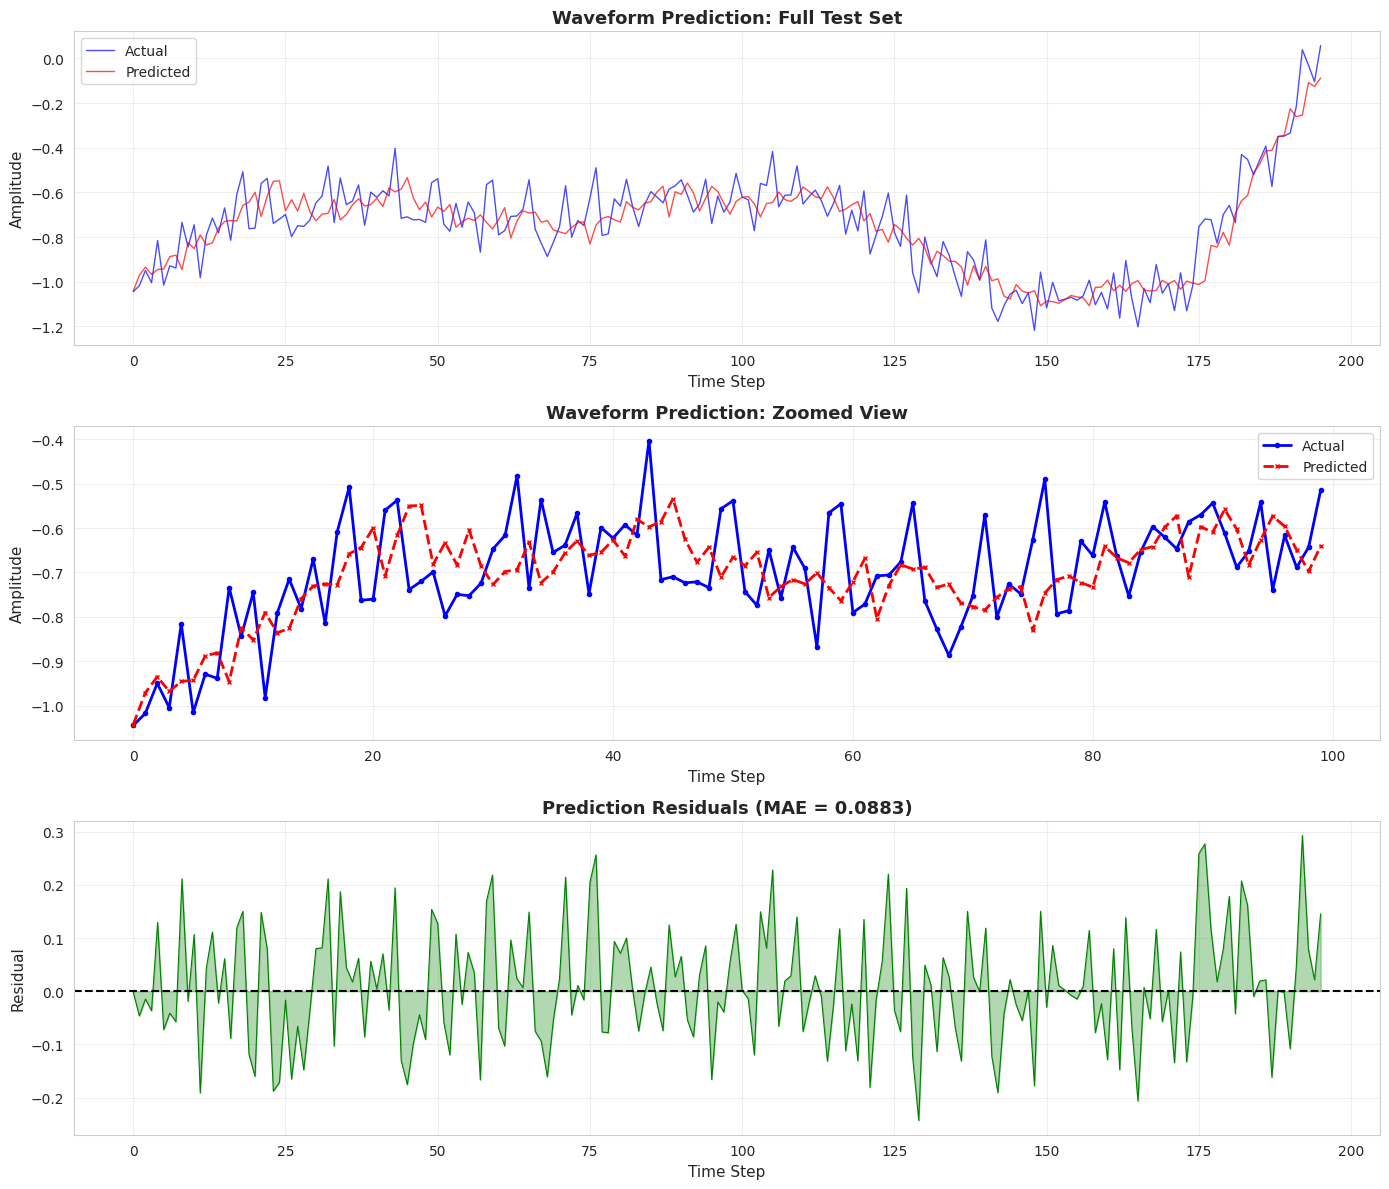

In [6]:
# 予測結果の可視化
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# 全体の比較
axes[0].plot(y_test, 'b-', linewidth=1, label='Actual', alpha=0.7)
axes[0].plot(y_pred_test, 'r-', linewidth=1, label='Predicted', alpha=0.7)
axes[0].set_xlabel('Time Step', fontsize=11)
axes[0].set_ylabel('Amplitude', fontsize=11)
axes[0].set_title('Waveform Prediction: Full Test Set', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# ズーム表示
zoom_start, zoom_end = 0, 100
axes[1].plot(range(zoom_start, zoom_end), y_test[zoom_start:zoom_end], 'b-',
             linewidth=2, label='Actual', marker='o', markersize=3)
axes[1].plot(range(zoom_start, zoom_end), y_pred_test[zoom_start:zoom_end], 'r--',
             linewidth=2, label='Predicted', marker='x', markersize=3)
axes[1].set_xlabel('Time Step', fontsize=11)
axes[1].set_ylabel('Amplitude', fontsize=11)
axes[1].set_title('Waveform Prediction: Zoomed View', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# 残差
residuals = y_test - y_pred_test
axes[2].plot(residuals, 'g-', linewidth=0.8)
axes[2].axhline(y=0, color='k', linestyle='--', linewidth=1.5)
axes[2].fill_between(range(len(residuals)), 0, residuals, alpha=0.3, color='green')
axes[2].set_xlabel('Time Step', fontsize=11)
axes[2].set_ylabel('Residual', fontsize=11)
axes[2].set_title(f'Prediction Residuals (MAE = {mean_absolute_error(y_test, y_pred_test):.4f})',
                  fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 5. ラグ数の影響

### 🤔 何点の過去データを見るべきか？

ラグ数（過去何点を見るか）は予測性能に大きく影響します。

```
【ラグ数の選び方の目安】

1. 周期性を考慮
   波形の周期 T がわかっている場合:
   → ラグ数 ≈ T 〜 2T が目安
   
   例: 周期20の正弦波
       → ラグ数 = 20〜40

2. 実験的に決定
   複数のラグ数を試して、
   交差検証で最良のものを選ぶ


【ラグ数が多すぎる問題】

  ラグ数 = 70 の場合:
  
  ・特徴量が70次元 → 過学習リスク
  ・最初の70点が使えない → データロス
  ・古い情報 → ノイズになる可能性


【ラグ数が少なすぎる問題】

  ラグ数 = 5 の場合:
  
  ・周期が長いパターンを捉えられない
  ・情報不足 → 予測精度が低い
```

### 異なるラグ数で実験してみましょう

---

## 4. ラグ数の影響

最適なラグ数を見つけます。

In [8]:
# 異なるラグ数でテスト
lag_values = [5, 10, 20, 30, 50, 70]

results = []

for n_lags in lag_values:
    # 特徴量作成
    X_lag, y_lag = create_lag_features(y, n_lags=n_lags)
    
    # 分割
    X_train_lag, X_test_lag, y_train_lag, y_test_lag = train_test_split(
        X_lag, y_lag, test_size=0.2, shuffle=False
    )
    
    # スケーリング
    scaler_lag = StandardScaler()
    X_train_lag_scaled = scaler_lag.fit_transform(X_train_lag)
    X_test_lag_scaled = scaler_lag.transform(X_test_lag)
    
    # 訓練
    mlp_lag = MLPRegressor(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        solver='adam',
        alpha=0.001,
        max_iter=500,
        early_stopping=True,
        random_state=42
    )
    mlp_lag.fit(X_train_lag_scaled, y_train_lag)
    
    # 評価
    y_pred_lag = mlp_lag.predict(X_test_lag_scaled)
    
    results.append({
        'n_lags': n_lags,
        'R²': r2_score(y_test_lag, y_pred_lag),
        'RMSE': np.sqrt(mean_squared_error(y_test_lag, y_pred_lag)),
        'MAE': mean_absolute_error(y_test_lag, y_pred_lag)
    })

df_lags = pd.DataFrame(results)

print("\nEffect of Number of Lags:")
print(df_lags.to_string(index=False))


Effect of Number of Lags:
 n_lags       R²     RMSE      MAE
      5 0.745908 0.114382 0.092167
     10 0.739797 0.115366 0.093922
     20 0.759363 0.110547 0.088322
     30 0.745405 0.113334 0.093298
     50 0.703690 0.122303 0.096661
     70 0.663346 0.131139 0.107865


---

## 5.5 異なる波形タイプでの予測

### 🎯 波形の特性と予測難易度

異なる波形タイプでMLPの予測性能を比較します。

```
【4つの波形と予測の難しさ】

1. Complex Harmonic（複雑な高調波）
   特性: 周期的、規則的
   予測: ⭐⭐ 比較的容易
   理由: パターンが繰り返される

2. Damped Oscillation（減衰振動）
   特性: 振幅が時間とともに減少
   予測: ⭐⭐⭐ 中程度
   理由: トレンド（減衰）を学習する必要

3. AM Signal（振幅変調）
   特性: 2つの周期が重なる
   予測: ⭐⭐⭐⭐ やや困難
   理由: 長いパターンと短いパターンの両方を捉える必要

4. Chirp（チャープ）
   特性: 周波数が変化
   予測: ⭐⭐⭐⭐⭐ 最も困難
   理由: 非定常的、過去のパターンが将来に当てはまらない
```

### 4つの波形を比較してみましょう

---

## 5. 異なる波形タイプでの予測

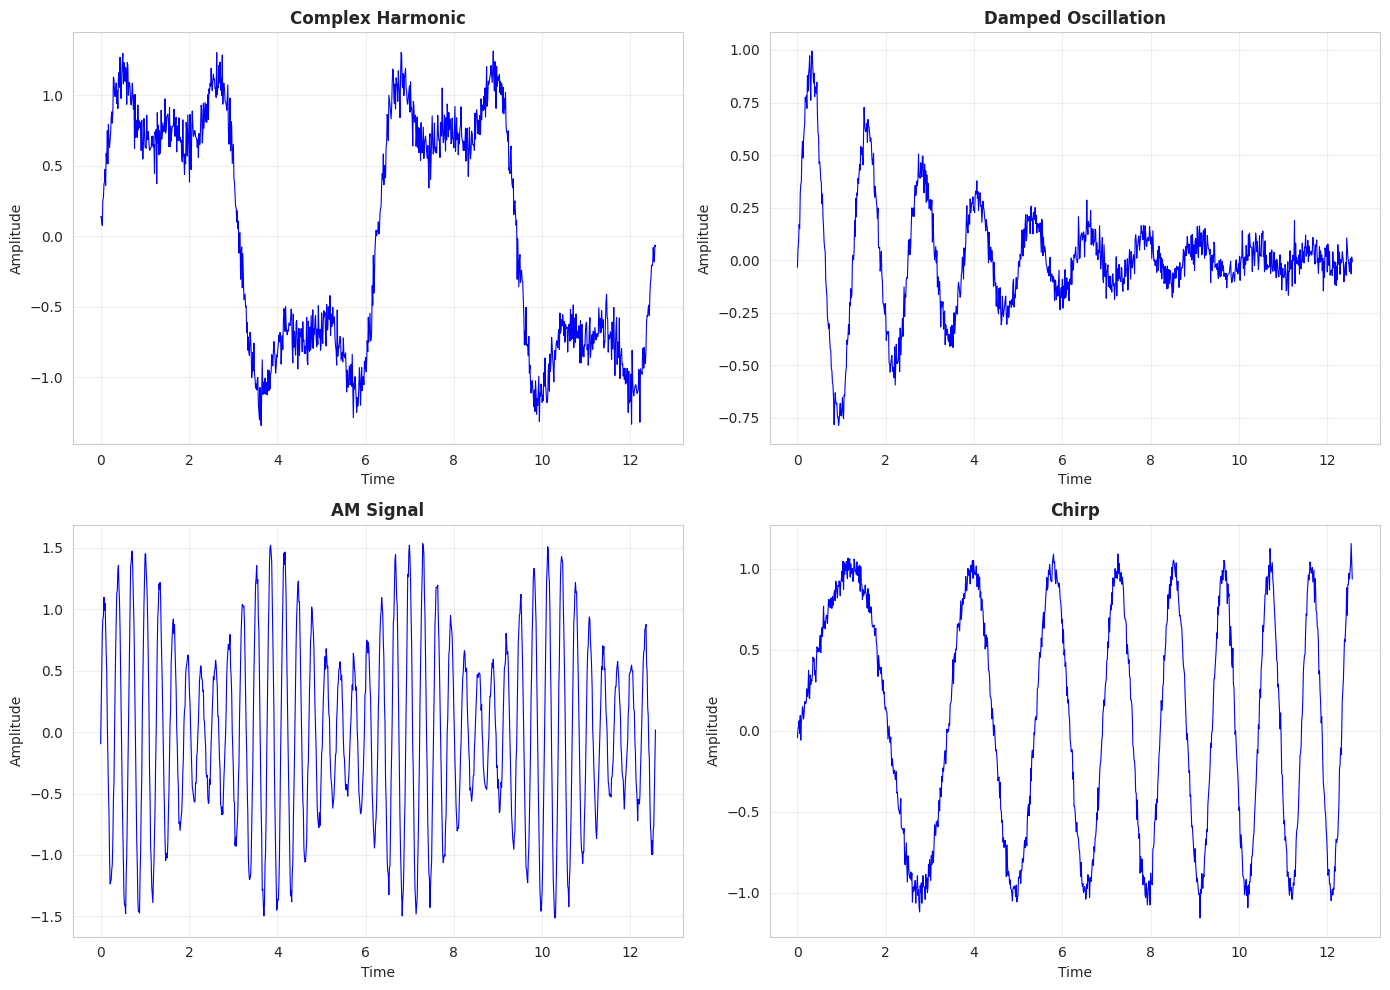

In [10]:
# すべての波形を生成
waveforms = {
    'Complex Harmonic': generate_complex_waveform(1000, 0.1),
    'Damped Oscillation': generate_damped_oscillation(1000, 0.3, 0.05),
    'AM Signal': generate_am_signal(1000, 20, 2, 0.05),
    'Chirp': generate_chirp(1000, 0.05)
}

# 可視化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, (name, (t, y_wave)) in enumerate(waveforms.items()):
    axes[idx].plot(t, y_wave, 'b-', linewidth=0.8)
    axes[idx].set_xlabel('Time', fontsize=10)
    axes[idx].set_ylabel('Amplitude', fontsize=10)
    axes[idx].set_title(name, fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 6. 多ステップ予測

### 🔮 1ステップ予測 vs 多ステップ予測

```
【1ステップ予測（これまでやってきたこと）】

  入力: 過去n点 [y(t-n), ..., y(t-1)]
  出力: 次の1点 y(t)
  
  例:
    [0.3, 0.5, 0.8, 1.0] → 0.7
    
  特徴:
    - 直前の値を知っている
    - 誤差が蓄積しない
    - 比較的簡単


【多ステップ予測（実用で重要）】

  入力: 過去n点 [y(t-n), ..., y(t-1)]
  出力: 未来のk点 [y(t), y(t+1), ..., y(t+k-1)]
  
  例（10ステップ先まで予測）:
    [0.3, 0.5, 0.8, 1.0] → [0.7, 0.4, 0.1, -0.3, ...]
    
  特徴:
    - 途中の値は推測
    - 誤差が蓄積する
    - 困難だが実用的
```

---

### 🔄 再帰的予測のメカニズム

**再帰的予測（Recursive/Autoregressive Prediction）** は、
予測値を次の入力として使い、繰り返し予測する手法です。

```
【再帰的予測の流れ】

ステップ1:
  入力: [y(1), y(2), y(3), y(4)]  ← 実測値
  予測: ŷ(5) = 0.7

ステップ2:
  入力: [y(2), y(3), y(4), ŷ(5)]  ← ŷ(5)は予測値！
  予測: ŷ(6) = 0.4

ステップ3:
  入力: [y(3), y(4), ŷ(5), ŷ(6)]  ← 予測値が増える
  予測: ŷ(7) = 0.2

ステップ4:
  入力: [y(4), ŷ(5), ŷ(6), ŷ(7)]  ← ほぼ予測値
  予測: ŷ(8) = ...

  ...繰り返し...

ステップ10:
  入力: [ŷ(7), ŷ(8), ŷ(9), ŷ(10)]  ← 全て予測値！
  予測: ŷ(11) = ???
```

---

### ⚠️ 誤差蓄積の問題

再帰的予測の最大の課題は **誤差の蓄積** です。

```
【誤差蓄積のメカニズム】

実測値: y(5) = 0.70
予測値: ŷ(5) = 0.73  （誤差 = +0.03）
                 ↓
            この誤差が次のステップに影響
                 ↓
実測値: y(6) = 0.40
予測値: ŷ(6) = 0.45  （誤差 = +0.05）← 誤差が大きくなる
                 ↓
            さらに影響が蓄積
                 ↓
実測値: y(10) = 0.20
予測値: ŷ(10) = 0.55  （誤差 = +0.35）← 大幅にずれる


【なぜ誤差が蓄積するのか？】

1. 予測値 ≠ 実測値
   どんなに良いモデルでも誤差ゼロは不可能

2. 誤った入力からの予測
   予測値を入力に使うため、間違った情報で予測
   
3. 誤差の連鎖反応
   1回の誤差が次の誤差に影響し、雪だるま式に増加


【視覚的な理解】

ステップ数と誤差の関係:

  誤差
   ↑
   │         ╱ ← 誤差が指数的に増加
   │       ╱
   │     ╱
   │   ╱
   │ ╱
   └──────────→ ステップ数
     1  5  10  20
```

---

### 📉 誤差蓄積の数学的理解

各ステップの予測誤差を $\epsilon_t$ とすると:

$$\hat{y}_{t+1} = f(\hat{y}_t, \hat{y}_{t-1}, ...) + \epsilon_{t+1}$$

誤差は近似的に:

$$\text{累積誤差} \approx \sum_{i=1}^{k} \epsilon_i + \text{(誤差の相互作用)}$$

```
【経験則】

  予測精度はステップ数の増加とともに低下:
  
  ステップ    予測精度
  ─────────  ──────────
     1-3      高い (R² > 0.9)
     4-10     中程度 (R² = 0.5-0.9)
    11-20     低い (R² < 0.5)
    20+       ほぼランダム
  
  ※ 実際の低下速度はデータの性質に依存
```

---

### 💡 多ステップ予測を改善する方法

```
【方法1: 直接多出力モデル】

  入力: [y(t-n), ..., y(t-1)]
  出力: [y(t), y(t+1), ..., y(t+k)]  ← 一度に複数出力
  
  メリット: 誤差が蓄積しない
  デメリット: 出力が固定、柔軟性がない


【方法2: 教師強制（Teacher Forcing）の訓練】

  訓練時: 正解値を入力に使用
  予測時: 予測値を入力に使用
  
  問題: 訓練と予測で挙動が異なる


【方法3: Scheduled Sampling】

  訓練初期: 正解値を使用
  訓練後期: 徐々に予測値を使用
  
  → 予測時の誤差に対する耐性を学習


【方法4: アンサンブル】

  複数のモデルで予測し、平均を取る
  → 個々のモデルの誤差を相殺


【方法5: 予測区間の推定】

  点予測だけでなく、信頼区間も予測
  → 予測の不確実性を明示
```

---

### 🎯 実務でのアドバイス

| シナリオ | 推奨アプローチ |
|---------|---------------|
| 1-5ステップ先 | 再帰的予測でOK |
| 6-20ステップ先 | 直接多出力またはアンサンブル |
| 20ステップ以上 | 単純なベースラインと比較、信頼区間を必ず提示 |

再帰的に複数ステップ先を予測してみましょう。

---

## 6. 多ステップ予測

再帰的に複数ステップ先を予測します。

---

## まとめ

### 🎯 このノートブックで学んだこと

```
1. 回帰 vs 分類の違い
   - 出力: 連続値 vs カテゴリ
   - 損失関数: MSE vs クロスエントロピー
   - 評価指標: R², RMSE, MAE vs Accuracy, F1

2. 波形予測の基礎
   - ラグ特徴量による時系列→回帰問題への変換
   - 自己相関を利用した予測
   - 時系列データの正しい分割方法

3. 多ステップ予測の課題
   - 誤差蓄積のメカニズム
   - 再帰的予測の限界
   - 改善のためのアプローチ
```

---

### 📊 評価指標のチートシート

| 指標 | 数式 | 解釈 | いつ使う？ |
|------|------|------|-----------|
| **R²** | $1 - \frac{SS_{res}}{SS_{tot}}$ | 0〜1（1が最良）<br>変動の説明率 | 全般的な性能評価 |
| **RMSE** | $\sqrt{\frac{1}{n}\sum(y-\hat{y})^2}$ | 元の単位で解釈可能<br>大きな誤差に敏感 | 大きな誤差を重視 |
| **MAE** | $\frac{1}{n}\sum|y-\hat{y}|$ | 外れ値に頑健<br>誤差の平均 | 外れ値が多い場合 |

```
【評価指標の選び方】

Q: 外れ値が多い？
  → Yes: MAE を使用
  → No:  RMSE を使用

Q: 相対的な性能を比較したい？
  → Yes: R² を使用（0-1で比較しやすい）
  → No:  RMSE/MAE を使用（実際の誤差値）
```

---

### 🔧 MLPRegressorのパラメータガイド

```python
# 推奨設定テンプレート
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    # === ネットワーク構造 ===
    hidden_layer_sizes=(100, 50),  # 2層: 100ユニット→50ユニット
    activation='relu',              # ReLUが標準、tanh/logisticも可
    
    # === 最適化設定 ===
    solver='adam',                  # Adam推奨、小データならlbfgs
    learning_rate_init=0.001,       # 学習率（adamの初期値）
    
    # === 正則化 ===
    alpha=0.0001,                   # L2正則化（過学習防止）
    
    # === 訓練制御 ===
    max_iter=500,                   # 最大エポック数
    early_stopping=True,            # 検証スコアで早期終了
    validation_fraction=0.1,        # 早期終了用の検証データ割合
    n_iter_no_change=10,            # 改善なしで終了までのエポック数
    
    random_state=42                 # 再現性のため
)
```

#### パラメータ調整のガイドライン

| 問題 | 症状 | 対処法 |
|-----|------|--------|
| **過学習** | Train高/Test低 | alpha↑, 層/ユニット↓, early_stopping=True |
| **未学習** | Train低/Test低 | 層/ユニット↑, alpha↓, max_iter↑ |
| **収束しない** | 警告が出る | learning_rate_init↓, max_iter↑ |
| **不安定** | 結果がバラつく | random_state固定, batch_size調整 |

---

### ⏰ 時系列予測のベストプラクティス

```
【データ準備】

1. 時間順に並び替え
   df = df.sort_values('timestamp')

2. 欠損値の処理
   - 補間: df.interpolate()
   - 前値埋め: df.fillna(method='ffill')
   - 削除は最終手段

3. スケーリング
   - StandardScaler または MinMaxScaler
   - fit は訓練データのみで行う！


【特徴量エンジニアリング】

1. ラグ特徴量
   - 周期の1-2倍を目安に設定
   - 自己相関プロットで確認

2. 追加特徴量（オプション）
   - 移動平均: rolling(window=k).mean()
   - 差分: diff()
   - 時間特徴量: 曜日、月、時間帯


【データ分割】

  ❌ shuffle=True
  ⭕ shuffle=False

  時系列: [========訓練========][==テスト==]
                    80%            20%
  
  交差検証: TimeSeriesSplit を使用


【評価】

1. 残差のプロット
   - パターンがないか確認
   - 自己相関がないか確認

2. 予測 vs 実測のプロット
   - ズレのパターンを視覚的に確認

3. 複数の評価指標
   - R², RMSE, MAE を併用
```

---

### 🚀 次のステップへ

```
【このノートブックから発展できること】

1. より高度な時系列モデル
   - ARIMA, SARIMA
   - Prophet
   - LSTM, Transformer

2. より複雑な問題
   - 多変量時系列
   - 不規則な時系列
   - 欠損のある時系列

3. 実データへの適用
   - 株価予測
   - 電力需要予測
   - センサーデータ異常検知


【MLPの限界を理解する】

  MLPRegressor で困難なケース:
  - 非常に長い依存関係（長期記憶が必要）
  - 大規模なデータ（LSTMの方が効率的）
  - リアルタイム予測（計算コスト）
  
  → これらの場合は LSTM や Transformer を検討
```

---

### ✅ 学習チェックリスト

- [ ] 分類と回帰の違いを説明できる
- [ ] R², RMSE, MAE の意味と使い分けを理解している
- [ ] ラグ特徴量の作成方法を理解している
- [ ] 時系列データでシャッフルしてはいけない理由を説明できる
- [ ] 多ステップ予測で誤差が蓄積する理由を理解している
- [ ] MLPRegressorの主要パラメータを調整できる

---

### 📚 練習問題

1. **評価指標の比較**: 意図的に外れ値を含むデータを作成し、RMSEとMAEの違いを確認してください

2. **ラグ数の最適化**: 自己相関プロットを作成し、最適なラグ数を決定してください

3. **波形の難易度**: 4種類の波形それぞれでモデルを訓練し、予測しやすさの違いを検証してください

4. **多ステップ予測の改善**: 直接多出力モデルを実装し、再帰的予測と性能を比較してください

5. **実データへの適用**: 気温や株価のデータを取得し、同様の手法を適用してください

---

**次のステップ**: ノートブック10で、より高度なニューラルネットワーク技術を学びます!

---

## まとめ

### 波形予測のベストプラクティス

1. **特徴量エンジニアリング**
   - ラグ特徴量: 過去の値を予測子として使用
   - 最適なラグ数: 信号の周期性に依存
   - 微分特徴量: 変化率も有用

2. **アーキテクチャ**
   - 開始: (100, 50) または (200, 100)
   - 複雑なパターン: より深いネットワーク
   - 入力サイズ = ラグ特徴量の数

3. **訓練のポイント**
   - 時系列データはシャッフルしない!
   - Early stoppingを使用
   - StandardScalerで特徴量をスケーリング

4. **評価指標**
   - R²: 説明率
   - RMSE: 二乗平均平方根誤差
   - MAE: 平均絶対誤差

5. **多ステップ予測**
   - 再帰的: 1ステップずつ予測してフィードバック
   - 誤差蓄積: ステップが増えると精度低下
   - 直接的多出力モデルも検討

### MLPRegressorの注意点

- **分類との違い**: 出力が連続値
- **活性化関数**: 出力層は線形 (恒等関数)
- **損失関数**: 平均二乗誤差 (MSE)

### 実践的アドバイス

1. まずシンプルなモデルから開始
2. ラグ数を実験的に決定
3. 学習曲線で診断
4. 予測を可視化して確認
5. 残差分析で改善点を発見

---

**次のステップ**: ノートブック10で、より高度なニューラルネットワーク技術を学びます!
